# PGD attacks

This notebook tests **EuroSAT ResNet18 model** on images modified with **PGD attacks**.

### 1. Setup environment and imports

In [93]:
import sys, os, re
sys.path.append(os.path.abspath(".."))

if not hasattr(sys, "frozen"):
    os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"
import random
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
import glob
import numpy as np
import tifffile
from torchvision import transforms

from src.training.simple_cnn import SimpleCNN
from src.data.dataloader import get_dataloaders
from src.attacks.evaluate import evaluate_pgd             
from src.attacks.metrics_eval import evaluate_adv, plot_confusion_matrix  
from src.attacks.utils import unnormalize,select_rgb_bands, gdal_style_scale, scale_for_display, load_and_prepare, DEFAULT_MEAN,DEFAULT_STD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_name = "resnet50" # or resnet18 simplecnn
data_dir = '../data/raw'
out_dir = '../data/adv/adv_4'
batch_size = 64

Using device: cpu


- Get path

In [ ]:
if model_name == "resnet18":
        checkpoint_path = "../experiments/checkpoints/resnet18_e.pth"
elif model_name == "resnet50":
        checkpoint_path = "../experiments/checkpoints/resnet50_e2.pth"


### 2. Load data and model

- Load dataloaders

In [95]:
train_loader, val_loader, test_loader, classes = get_dataloaders(data_dir=data_dir, batch_size=batch_size)
print(f'Loaded {len(classes)} classes: {classes}')

num_classes = len(classes)

Loaded 4 classes: ['AnnualCrop', 'Forest', 'Residential', 'River']


- Load model

In [87]:
if model_name.lower() == "resnet18":
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
elif model_name.lower() == "resnet50":
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
elif model_name.lower() == "simplecnn":
    model = SimpleCNN(num_classes=num_classes)
else:
    raise ValueError(f"Unsupported model_name: {model_name}")


- Load trained weights

In [96]:
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 3. Run PGD attacks and save adversarial images 

In [70]:
eps = 0.0005
alpha = eps / 4
iters = 20
smooth_sigma=1.0

res = evaluate_pgd(
    model=model,
    dataloader=test_loader,
    device=device,
    eps=eps,           
    alpha=alpha,        
    iters=iters,
    out_dir=out_dir,
    save_every=1,
    max_save=100,
    smooth_sigma=smooth_sigma,                     

)

print('PGD run result:', res)


/Users/joseantonioruizheredia/Code/Python/ml-satellite-adv/src/attacks/utils.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(t.mean).view(-1, 1, 1)
/Users/joseantonioruizheredia/Code/Python/ml-satellite-adv/src/attacks/utils.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(t.std).view(-1, 1, 1)


KeyboardInterrupt: 

### 4. Evaluate saved adversarial images for each epsilon

In [97]:
# Verificar tamaño de entrada del modelo
print("\n=== Verificando tamaño de entrada del modelo ===")
try:
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    output = model(dummy_input)
    print(f"✓ El modelo acepta 224x224")
except:
    print(f"✗ El modelo NO acepta 224x224, probando 64x64...")
    try:
        dummy_input = torch.randn(1, 3, 64, 64).to(device)
        output = model(dummy_input)
        print(f"✓ El modelo acepta 64x64")
    except:
        print(f"✗ Error desconocido")


=== Verificando tamaño de entrada del modelo ===
✓ El modelo acepta 224x224


- Evaluation of metrics

In [98]:
print(f"\n=== Model Evaluation on Adversarial Images ===")

metrics_adv = evaluate_adv(
    adv_folder=out_dir,
    model_path=checkpoint_path,
    data_dir=data_dir,
    batch_size=batch_size,
    model_name=model_name,
    device=device,
    mean_std_sample_size=2000,
    image_pattern="*.tif"
)

print(f"Num images: {metrics_adv['num_images']}")

print(f"Accuracy: {metrics_adv['accuracy']*100:.2f}%")
print(f"Loss: {metrics_adv['loss']:.4f}")
print(f"Precision: {metrics_adv['precision']:.4f}")
print(f"Recall: {metrics_adv['recall']:.4f}")
print(f"F1-score: {metrics_adv['f1']:.4f}")

print("\nClassification metrics per category:\n\n", metrics_adv["classification_report"])



=== Model Evaluation on Adversarial Images ===
Num images: 100
Accuracy: 32.00%
Loss: 5.0276
Precision: 0.3514
Recall: 0.2750
F1-score: 0.1897

Classification metrics per category:

               precision    recall  f1-score   support

  AnnualCrop     0.4054    1.0000    0.5769        30
      Forest     0.0000    0.0000    0.0000        26
 Residential     0.0000    0.0000    0.0000        24
       River     1.0000    0.1000    0.1818        20

    accuracy                         0.3200       100
   macro avg     0.3514    0.2750    0.1897       100
weighted avg     0.3216    0.3200    0.2094       100



- Confusion Matrix

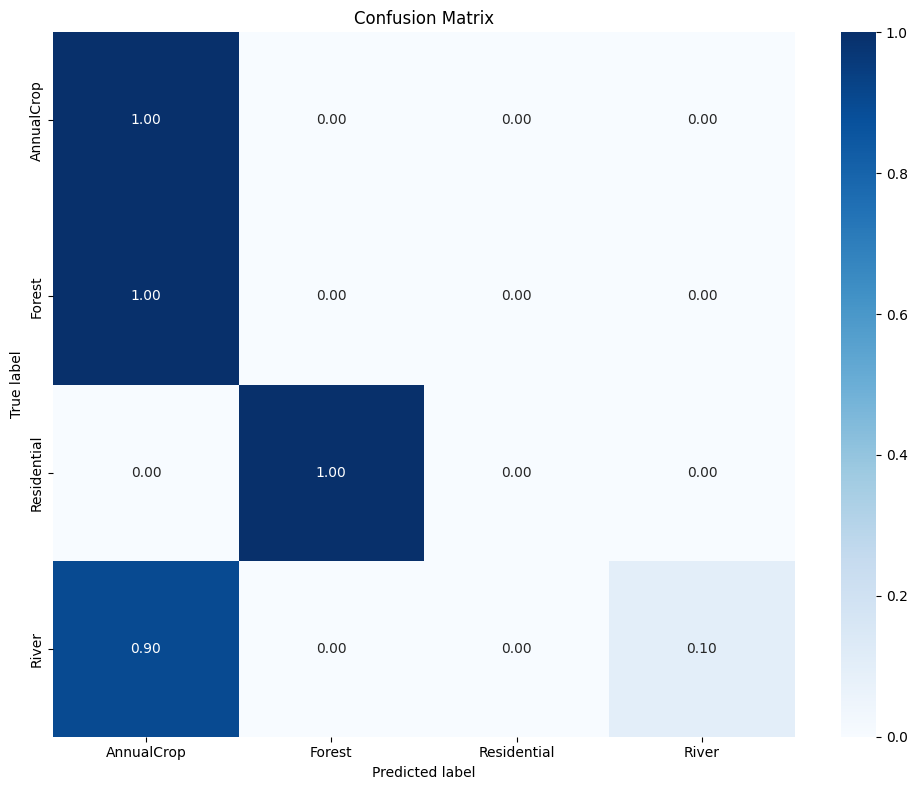

In [99]:
plot_confusion_matrix(metrics_adv['confusion_matrix'], metrics_adv['class_names'], normalize=True)

- Show a small sample of images 

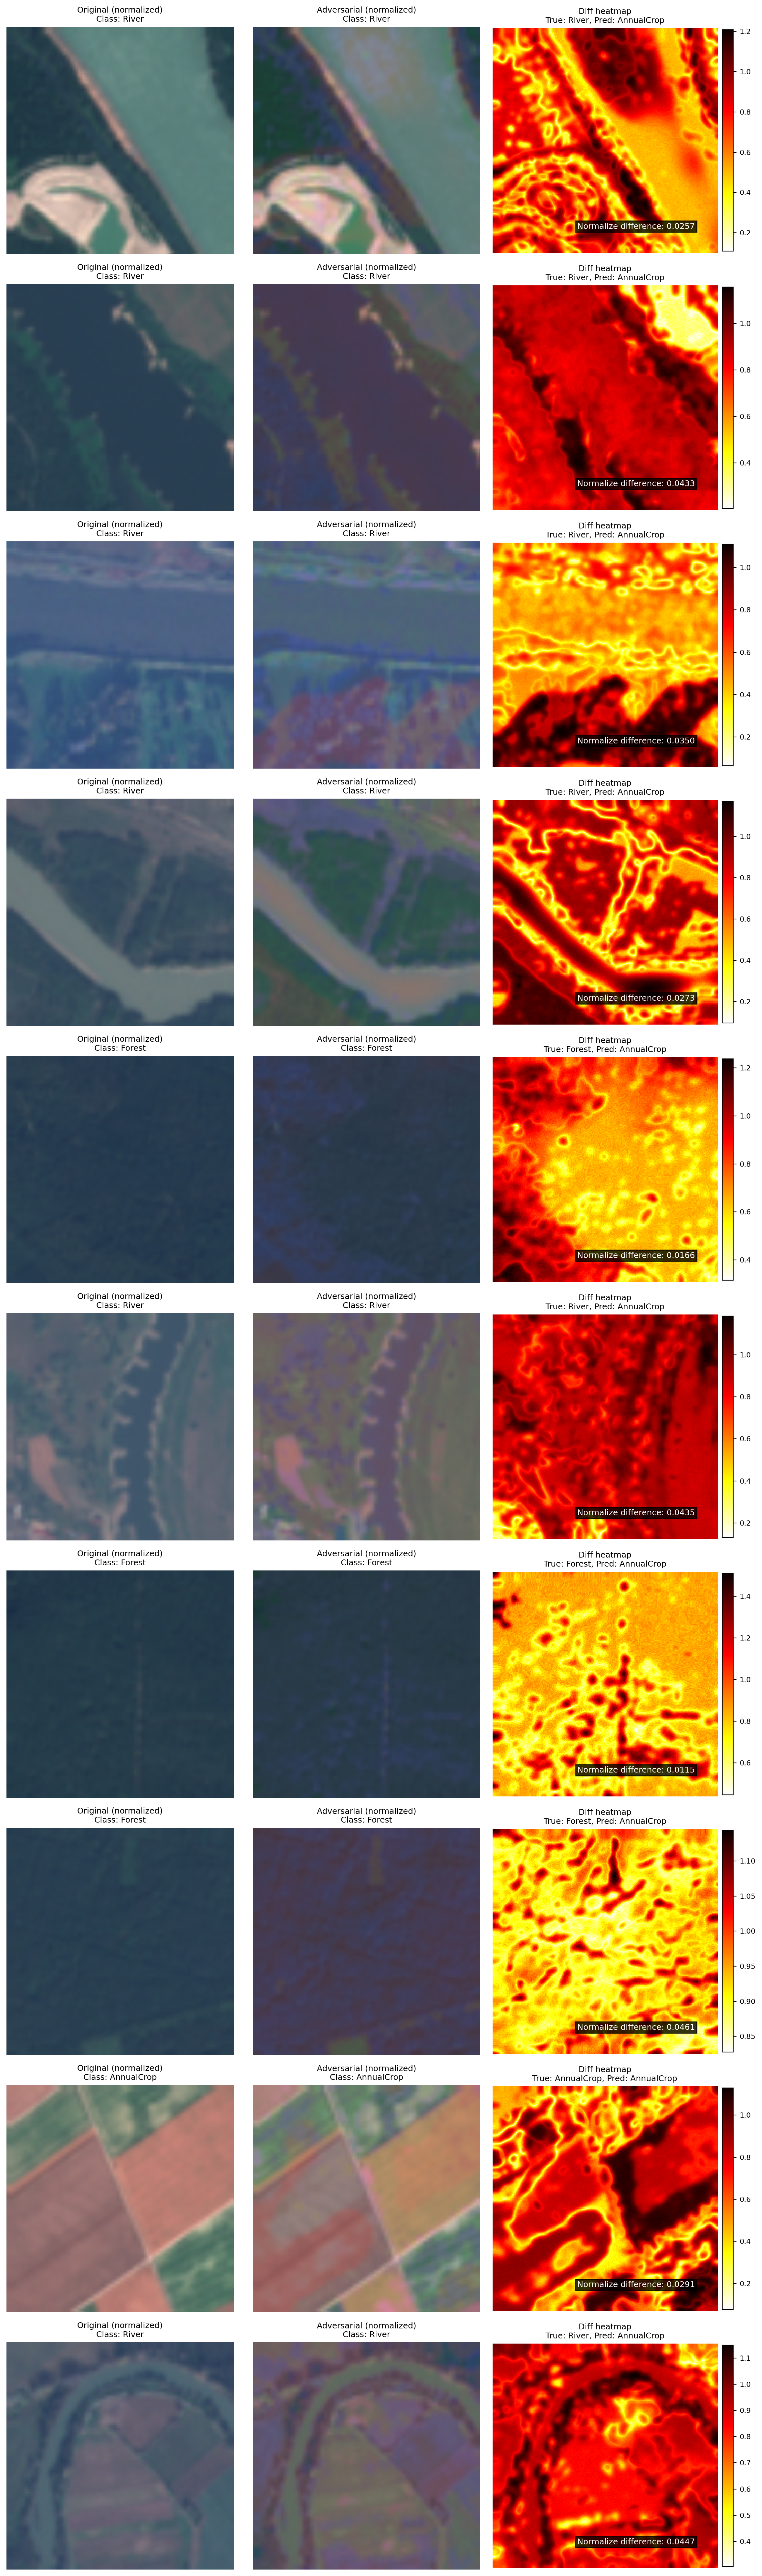

In [100]:
# Show a small sample of images 
adv_folder = out_dir
raw_folder = '../data/raw'

adv_paths = sorted(glob.glob(os.path.join(adv_folder, "*.tif")))

# --- Match original raw images ---
pairs = []
for adv_p in adv_paths:
    base = os.path.basename(adv_p)
    orig_base = re.sub(r"_true\d+_pred\d+\.tif$", ".tif", base)
    orig_candidates = glob.glob(os.path.join(raw_folder, "**", orig_base), recursive=True)
    if not orig_candidates:
        continue
    pairs.append((adv_p, orig_candidates[0]))

if len(pairs) == 0:
    print("No matching pairs found.")
else:
    random.shuffle(pairs)
    pairs = pairs[:10]

    fig, axs = plt.subplots(len(pairs), 3, figsize=(12, 4 * len(pairs)), dpi=200)
    axs = np.atleast_2d(axs)
    
    # Extract mean and std from dataloader
    mean, std = DEFAULT_MEAN, DEFAULT_STD
    try:
        ds = test_loader.dataset
        if hasattr(ds, "dataset"):
            base_ds = ds.dataset
        else:
            base_ds = ds
        transform_obj = getattr(base_ds, "transform", None)
        if transform_obj and hasattr(transform_obj, "transforms"):
            for t in transform_obj.transforms:
                if t.__class__.__name__ == "Normalize":
                    mean = t.mean
                    std = t.std
                    break
    except Exception:
        pass
    
    MODEL_INPUT_SIZE = (224, 224)
    
    pred_transform = transforms.Compose([
        transforms.Resize(MODEL_INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
    
    display_transform = transforms.Compose([
        transforms.Resize(MODEL_INPUT_SIZE),
        transforms.ToTensor(),
    ])
    
    model.eval()
    
    for i, (adv_p, orig_p) in enumerate(pairs): 
        # Cargar imagen original para visualización
        orig_img = load_and_prepare(orig_p, size=MODEL_INPUT_SIZE, is_raw=True)
        
        # *** FIX: Las imágenes adversariales están guardadas como uint8 RGB [0-255] ***
        adv_raw = tifffile.imread(adv_p)
        
        # Convertir a HWC si es necesario
        if adv_raw.ndim == 3 and adv_raw.shape[0] in [3,4,13]:
            adv_raw = np.transpose(adv_raw, (1,2,0))
        
        # Las adversariales ya son RGB uint8, solo tomar primeras 3 bandas
        if adv_raw.shape[2] >= 3:
            adv_rgb = adv_raw[:, :, :3]
        else:
            adv_rgb = adv_raw
        
        # Resize
        from skimage.transform import resize
        adv_rgb_resized = resize(adv_rgb, MODEL_INPUT_SIZE, preserve_range=True, anti_aliasing=True)
        
        # CRÍTICO: Las adversariales son uint8 [0-255], simplemente normalizar a [0,1]
        # NO aplicar gdal_style_scale porque no son valores raw
        adv_img_display = np.clip(adv_rgb_resized, 0, 255).astype(np.float32) / 255.0
        
        # Convertir a PIL para predicción (usar el mismo adv_rgb ya procesado)
        adv_pil = Image.fromarray(adv_rgb.astype(np.uint8))
        
        # Para PREDICCIÓN: con normalización
        adv_tensor = pred_transform(adv_pil).unsqueeze(0).to(device)
        
        # Get true class name from original path
        true_class_name = os.path.basename(os.path.dirname(orig_p))
        
        # Predict adversarial image
        try:
            with torch.no_grad():
                outputs = model(adv_tensor)
                pred_idx = outputs.argmax(1).item()
                pred_class_name = classes[pred_idx]
        except Exception as e:
            print(f"Error predicting {adv_p}: {e}")
            pred_class_name = "Error"
        
        ax0, ax1, ax2 = axs[i] 
        
        # Original 
        ax0.imshow(orig_img) 
        ax0.set_title(f"Original (normalized)\nClass: {true_class_name}", fontsize=9) 
        ax0.axis("off") 
        
        # Adversarial 
        ax1.imshow(adv_img_display) 
        ax1.set_title(f"Adversarial (normalized)\nClass: {true_class_name}", fontsize=9) 
        ax1.axis("off") 
        
        # Difference heatmap 
        diff = np.mean(np.abs(adv_img_display - orig_img), axis=2) 
        p99 = np.percentile(diff, 90) 
        diff_clipped = np.clip(diff / (p99 + 1e-12), 0, 10) 
        diff_vis = diff_clipped ** 0.5 
        im = ax2.imshow(diff_vis, cmap='hot_r', interpolation='nearest') 
        
        ax2.set_title(f"Diff heatmap\nTrue: {true_class_name}, Pred: {pred_class_name}", fontsize=9) 
        ax2.axis("off") 
        ax2.text( 
                 0.9, 0.1, 
                 f"Normalize difference: {diff.mean():.4f}", 
                 color='white', 
                 fontsize=9, 
                 ha='right', 
                 va='bottom', 
                 transform=ax2.transAxes, 
                 bbox=dict(facecolor='black', alpha=0.8, pad=2) 
                ) 
        cbar = fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.02)
        cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()